# Final Assignment by Julian Eppelsheimer - <br> Advanced Data Science Capstone Project

## <u>Motivation | Business Problem</u><br>

### Hello together :) My name is Julian. I am a Chemistry PhD student in Germany who wants to take a deeper look into Data Science. Currently I am living a Mainz, which is the next big city to Frankfurt, in rhineland palatinate.
### In this region, the cultivation and eventual sale of wine contributes a large share of the gross domestic product. Due to this fact, I have chosen a dataset for my final submission that deals with the quality classification of different wines.
### The dataset can be found at the <u>Kaggle</u> website under: https://www.kaggle.com/uciml/red-wine-quality-cortez-et-al-2009
### In the following folium map you can see a part of the area of rhineland palatinate. All the green spots are vineyards with vinegrapes. 

In [1]:
import folium
map_nearby_venues = folium.Map(location=[49.881388395508075, 8.121492095985705], zoom_start=13)#, tiles="Stamen Terrain")
map_nearby_venues

### From the website "https://www.destatis.de/DE/Themen/Branchen-Unternehmen/Landwirtschaft-Forstwirtschaft-Fischerei/Wein/Tabellen/rebflaeche-bundeslaender.html" you can see the area of vineyards for each German State. <br>Please notice, that rhineland palatinate has the highest area of vineyards in Germany with a total contribution of ca. 31%.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
url = "https://www.destatis.de/DE/Themen/Branchen-Unternehmen/Landwirtschaft-Forstwirtschaft-Fischerei/Wein/Tabellen/rebflaeche-bundeslaender.html"
read_url = pd.read_html(url, encoding="UTF-8")
read_url[0]["Hektar (ha)"] = [i.replace("\xa0","") for i in read_url[0]["Hektar (ha)"]]
read_url[0]["Hektar (ha)"] = pd.to_numeric(read_url[0]["Hektar (ha)"])
read_url[0].style.highlight_max(subset=7, color = 'blue', axis = 0)
#read_url[0]


,Bundesländer,Hektar (ha)
0,Deutschland,103079
1,Baden-Württemberg,27263
2,Bayern,6219
3,Brandenburg,35
4,Hessen,3648
5,Mecklenburg-Vorpommern,6
6,Nordrhein-Westfalen,20
7,Rheinland-Pfalz,64461
8,Saarland,126
9,Sachsen,464


['Rheinland-Pfalz', 'Rest']
[64461, 141697]


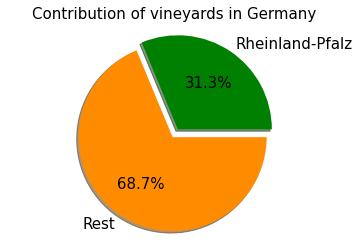

In [3]:
# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = ["Rheinland-Pfalz", "Rest"]
sizes = [read_url[0].loc[7, "Hektar (ha)"], (read_url[0]["Hektar (ha)"].sum()-read_url[0].loc[7, "Hektar (ha)"])]
print(labels)
print(sizes)
explode = (0, 0.1)  # only "explode" the 2nd slice (i.e. 'Hogs')

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=0, colors=["green", "darkorange"], textprops={'fontsize': 15})
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title("Contribution of vineyards in Germany",fontdict={'fontsize': 15, 'fontweight': 'medium'})
plt.show()

# 1) Data Exploration

## 1.1) Import needed libraries

In [4]:
#Standard libraries
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statistics
from statistics import mean 
from IPython.display import Image

#Preprocessing
from sklearn.model_selection import train_test_split

#Pipeline
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

#Classifiert
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree, metrics, svm

#Scaler
from sklearn.preprocessing import Normalizer, MaxAbsScaler, MinMaxScaler, StandardScaler, RobustScaler

#Evaluation
from sklearn.metrics import classification_report, f1_score, jaccard_score, log_loss

## 1.2) Defining functions

In [5]:
def reduce_corr_matrix(corr_matrix):
    corr_matrix = corr_matrix.copy()
    start = 0
    for i in range(0,len(corr_matrix), 1):
        for j in range(start, len(corr_matrix),1):
            corr_matrix.iloc[j][i] = np.nan
        start = start+1
    return corr_matrix

In [6]:
def display_model(Y_test, yhat):
    """
    Y_test: Test-Data (Target)
    yhat: Predicted Data (Target) 
    """
    Y_test_std = Y_test.std()
    Y_test_mean = Y_test.mean()
    Y_test_median = np.median(Y_test)
    sns.set_style("darkgrid")
    sns.kdeplot(Y_test, label='Actual Value')
    sns.kdeplot(yhat, label='Predicted Value')
    plt.axvline(Y_test_mean, 1, 0, color='black', label='Mean of Test-Data')
    plt.axvline(Y_test_mean+Y_test_std, 1, 0, color='grey')
    plt.axvline(Y_test_mean-Y_test_std, 1, 0, color='grey', label='+/- 1 standard deviation')
    plt.axvline(Y_test_median, 1, 0, color='darkblue', label='Median of Test-Data')
    plt.legend()
    plt.title('Test Data Prediction vs. Actual Value')
    plt.show()

## 1.3) Extract-transform-load

In [7]:
df = pd.read_csv("winequality-red.csv", encoding="UTF-8")

In [8]:
df

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
1,7.8,0.880,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5
2,7.8,0.760,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,5
3,11.2,0.280,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,6
4,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
...,...,...,...,...,...,...,...,...,...,...,...,...
1594,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,5
1595,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,0.76,11.2,6
1596,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,6
1597,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2,5


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


In [10]:
df.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983,5.636023
std,1.741096,0.179060,0.194801,1.409928,0.047065,10.460157,32.895324,0.001887,0.154386,0.169507,1.065668,0.807569
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000,6.000000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997835,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


In [11]:
df["quality"].unique()

array([5, 6, 7, 4, 8, 3], dtype=int64)

In [12]:
df_grouped = df.groupby("quality").count()

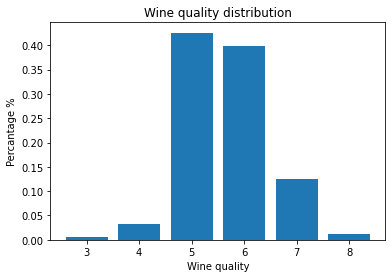

In [13]:
plt.bar(df_grouped.index, (df_grouped["fixed acidity"]/len(df)))
plt.title("Wine quality distribution")
plt.xlabel("Wine quality")
plt.ylabel("Percantage %")
plt.show()

### We take a binary approach: All vines with quality >=7 are "Excellent" (1), all vines with quality <7 are "OK" (0)

In [14]:
df.quality = [1 if i>=7 else 0 for i in df.quality]

In [15]:
df

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,0
1,7.8,0.880,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,0
2,7.8,0.760,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,0
3,11.2,0.280,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,0
4,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1594,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,0
1595,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,0.76,11.2,0
1596,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,0
1597,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2,0


In [16]:
df_grouped_new = df.groupby("quality").count()
df_grouped_new 

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
quality,,,,,,,,,,,
0,1382,1382,1382,1382,1382,1382,1382,1382,1382,1382,1382
1,217,217,217,217,217,217,217,217,217,217,217


['OK', 'Excellent']
quality
0    1382
1     217
Name: fixed acidity, dtype: int64


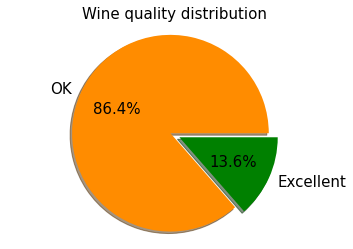

In [17]:
# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = ["Excellent" if i == 1 else "OK" for i in df_grouped_new.index]
sizes = df_grouped_new["fixed acidity"]
print(labels)
print(sizes)
explode = (0, 0.1)  # only "explode" the 2nd slice (i.e. 'Hogs')

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=0, colors=["darkorange", "green"], textprops={'fontsize': 15})
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title("Wine quality distribution",fontdict={'fontsize': 15, 'fontweight': 'medium'})
plt.show()

## 1.4) Feature Creation

### Checking for any linear correlation between features and label (quality) 

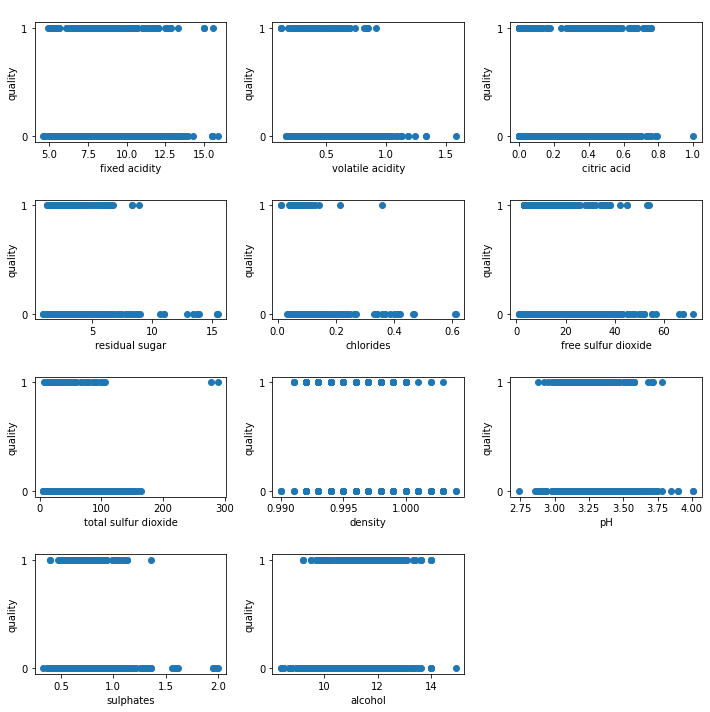

In [18]:
i,j = 0,0
plt.figure(figsize=(10,10)) 
for column in df.columns:
    if column != "quality":
        ax = plt.subplot2grid((math.ceil((len(df.columns)-1)/3),3), (i,j))
        x = [float("{:.3f}".format(i)) for i in df[column]]
        y = df["quality"]
        ax.set_title(" ")
        ax.scatter(x,y, marker="o")#, edgecolor="black", color="white")
        ax.set_xlabel(column)
        ax.set_ylabel("quality")
        ax.set_yticks([0,1])
        if j <= 1:
            j = j+1
        else:
            j = 0
            i = i+1
            
plt.tight_layout()
plt.show()


### Using a Correlation Matrix to reduce dimensionality

In [19]:
df_corr_matrix = df.corr()
df_corr_matrix

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
fixed acidity,1.000000,-0.256131,0.671703,0.114777,0.093705,-0.153794,-0.113181,0.668047,-0.682978,0.183006,-0.061668,0.120061
volatile acidity,-0.256131,1.000000,-0.552496,0.001918,0.061298,-0.010504,0.076470,0.022026,0.234937,-0.260987,-0.202288,-0.270712
citric acid,0.671703,-0.552496,1.000000,0.143577,0.203823,-0.060978,0.035533,0.364947,-0.541904,0.312770,0.109903,0.214716
residual sugar,0.114777,0.001918,0.143577,1.000000,0.055610,0.187049,0.203028,0.355283,-0.085652,0.005527,0.042075,0.047779
chlorides,0.093705,0.061298,0.203823,0.055610,1.000000,0.005562,0.047400,0.200632,-0.265026,0.371260,-0.221141,-0.097308
free sulfur dioxide,-0.153794,-0.010504,-0.060978,0.187049,0.005562,1.000000,0.667666,-0.021946,0.070377,0.051658,-0.069408,-0.071747
total sulfur dioxide,-0.113181,0.076470,0.035533,0.203028,0.047400,0.667666,1.000000,0.071269,-0.066495,0.042947,-0.205654,-0.139517
density,0.668047,0.022026,0.364947,0.355283,0.200632,-0.021946,0.071269,1.000000,-0.341699,0.148506,-0.496180,-0.150460
pH,-0.682978,0.234937,-0.541904,-0.085652,-0.265026,0.070377,-0.066495,-0.341699,1.000000,-0.196648,0.205633,-0.057283
sulphates,0.183006,-0.260987,0.312770,0.005527,0.371260,0.051658,0.042947,0.148506,-0.196648,1.000000,0.093595,0.199485


<AxesSubplot:>

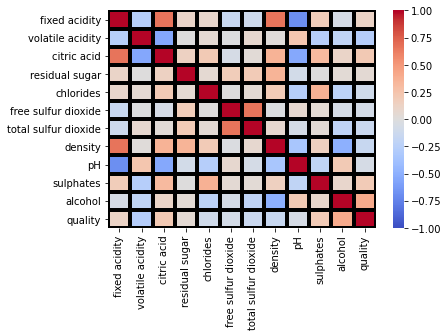

In [20]:
sns.heatmap(df_corr_matrix,  vmin=-1, vmax=1, center= 0, cmap= 'coolwarm', linewidths=3, linecolor='black')

In [21]:
reduced_df_corr = reduce_corr_matrix(df_corr_matrix)

In [22]:
reduced_df_corr

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
fixed acidity,NaN,-0.256131,0.671703,0.114777,0.093705,-0.153794,-0.113181,0.668047,-0.682978,0.183006,-0.061668,0.120061
volatile acidity,NaN,NaN,-0.552496,0.001918,0.061298,-0.010504,0.076470,0.022026,0.234937,-0.260987,-0.202288,-0.270712
citric acid,NaN,NaN,NaN,0.143577,0.203823,-0.060978,0.035533,0.364947,-0.541904,0.312770,0.109903,0.214716
residual sugar,NaN,NaN,NaN,NaN,0.055610,0.187049,0.203028,0.355283,-0.085652,0.005527,0.042075,0.047779
chlorides,NaN,NaN,NaN,NaN,NaN,0.005562,0.047400,0.200632,-0.265026,0.371260,-0.221141,-0.097308
free sulfur dioxide,NaN,NaN,NaN,NaN,NaN,NaN,0.667666,-0.021946,0.070377,0.051658,-0.069408,-0.071747
total sulfur dioxide,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.071269,-0.066495,0.042947,-0.205654,-0.139517
density,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.341699,0.148506,-0.496180,-0.150460
pH,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.196648,0.205633,-0.057283
sulphates,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.093595,0.199485


<AxesSubplot:>

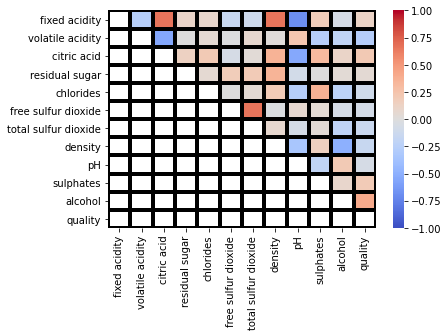

In [23]:
sns.heatmap(reduced_df_corr,  vmin=-1, vmax=1, center= 0, cmap= 'coolwarm', linewidths=3, linecolor='black')

### We define, that every value above 0.6 displays a "stong correlation" 

In [24]:
selected_df_corr = reduced_df_corr[abs(reduced_df_corr.iloc[:,:])>= 0.6]

In [25]:
selected_df_corr

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
fixed acidity,NaN,NaN,0.671703,NaN,NaN,NaN,NaN,0.668047,-0.682978,NaN,NaN,NaN
volatile acidity,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
citric acid,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
residual sugar,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
chlorides,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
free sulfur dioxide,NaN,NaN,NaN,NaN,NaN,NaN,0.667666,NaN,NaN,NaN,NaN,NaN
total sulfur dioxide,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
density,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
pH,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
sulphates,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<AxesSubplot:>

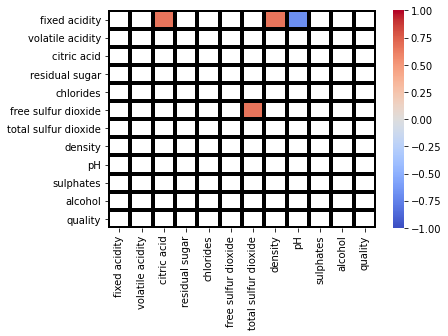

In [26]:
sns.heatmap(selected_df_corr,  vmin=-1, vmax=1, center= 0, cmap= 'coolwarm', linewidths=3, linecolor='black')

### The feature "fixed acidity" correlates strongly with "citric acid", "density" and "pH"; so these three columns/features can be dropped. <br>In addition to that "free sulfur dioxide" and "total sulfur dioxide" also correlate strongly. Therefor the "total sulfur dioxide" feature will be dropped aswell.

In [27]:
df.drop(labels=["citric acid", "density", "pH","total sulfur dioxide"], axis=1, inplace=True)

In [28]:
df

,fixed acidity,volatile acidity,residual sugar,chlorides,free sulfur dioxide,sulphates,alcohol,quality
0,7.4,0.700,1.9,0.076,11.0,0.56,9.4,0
1,7.8,0.880,2.6,0.098,25.0,0.68,9.8,0
2,7.8,0.760,2.3,0.092,15.0,0.65,9.8,0
3,11.2,0.280,1.9,0.075,17.0,0.58,9.8,0
4,7.4,0.700,1.9,0.076,11.0,0.56,9.4,0
...,...,...,...,...,...,...,...,...
1594,6.2,0.600,2.0,0.090,32.0,0.58,10.5,0
1595,5.9,0.550,2.2,0.062,39.0,0.76,11.2,0
1596,6.3,0.510,2.3,0.076,29.0,0.75,11.0,0
1597,5.9,0.645,2.0,0.075,32.0,0.71,10.2,0


### Splitting Data in Training and Testing sets

In [29]:
X_all = df.loc[:,"fixed acidity":"alcohol"].to_numpy()
X_all

array([[ 7.4  ,  0.7  ,  1.9  , ..., 11.   ,  0.56 ,  9.4  ],
       [ 7.8  ,  0.88 ,  2.6  , ..., 25.   ,  0.68 ,  9.8  ],
       [ 7.8  ,  0.76 ,  2.3  , ..., 15.   ,  0.65 ,  9.8  ],
       ...,
       [ 6.3  ,  0.51 ,  2.3  , ..., 29.   ,  0.75 , 11.   ],
       [ 5.9  ,  0.645,  2.   , ..., 32.   ,  0.71 , 10.2  ],
       [ 6.   ,  0.31 ,  3.6  , ..., 18.   ,  0.66 , 11.   ]])

In [30]:
Y_all = df.quality.to_numpy()
Y_all

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [31]:
X_train, X_test, Y_train, Y_test = train_test_split(X_all, Y_all, test_size=0.2, random_state=2)

In [32]:
print("X_train:", X_train.shape)
print("Y_train:", Y_train.shape)
print("X_test:", X_test.shape)
print("Y_test:", Y_test.shape)


X_train: (1279, 7)
Y_train: (1279,)
X_test: (320, 7)
Y_test: (320,)


# 2) Model Creation

### I will use the following five different classification models in order to find the best supervised machinelearning classifier for the used dataset: 

In [33]:
pd.DataFrame({"Abbreviation":["DTC", "RFC", "LR", "SVM", "KNN"], "Long Name": ["Decision Tree Classifier", "Random Forest Classifier","Logistic Regression","Support Vector Machine","K-Nearest Neighbors"]})


,Abbreviation,Long Name
0,DTC,Decision Tree Classifier
1,RFC,Random Forest Classifier
2,LR,Logistic Regression
3,SVM,Support Vector Machine
4,KNN,K-Nearest Neighbors


## 2.1) Testing different algorithms for their accuracy by using the train_set to train the model and the test_set to test the model - Cross-Validation

### To gain the best result, cross validation of the training set will be used according to the following graphic:
Source: https://scikit-learn.org/stable/modules/cross_validation.html

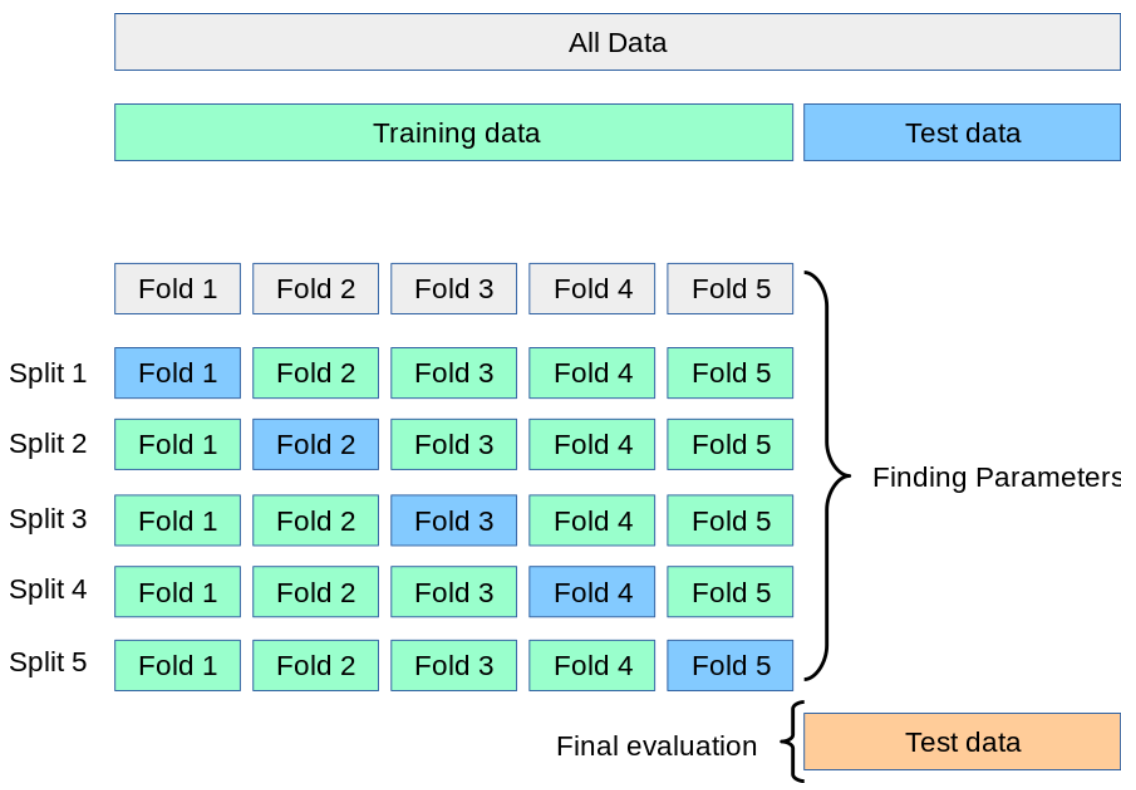

In [34]:
Image(filename='grid_search_cross_validation.png') 

Notice: I didn't scale the data yet. I like to see the scaler as hyperparameter for the regarding model, as suggested at:
https://towardsdatascience.com/normalization-vs-standardization-quantitative-analysis-a91e8a79cebf<br>
Also, i left all the hyperparameters of the algorithms as default.

### Creating a Pipeline with Classifier. Model evaluation is based on the "Accuracy_score".

In [35]:
results_clf = pd.DataFrame(columns=["CV_mean","CV_std","Model_acc"], index=["DTC", "RFC", "LR", "SVM", "KNN"])

list_Classifier= [
    ("DTC",tree.DecisionTreeClassifier()),
    ("RFC", RandomForestClassifier()),
    ("LR",LogisticRegression(max_iter=500)),
    ("SVM",svm.SVC()),
    ("KNN", KNeighborsClassifier())    
]

for clf in list_Classifier:
    pipe = Pipeline([clf])
    scores = cross_val_score(pipe, X_train, Y_train, cv=5, scoring="accuracy")
    results_clf.loc[clf[0],"CV_mean"] = float("{:.3f}".format(mean(scores)))#
    results_clf.loc[clf[0],"CV_std"] = float("{:.3f}".format(statistics.stdev(scores)))
    #print(f"Due to CV, the {clf[0]} model has an internal accuracy score of {mean(scores)} with a standarddeviation of {statistics.stdev(scores)}")
    #print(scores)
    pipe.fit(X_train, Y_train)
    yhat = pipe.predict(X_test)
    model_accuracy = metrics.accuracy_score(Y_test, yhat)
    results_clf.loc[clf[0],"Model_acc"] = float("{:.3f}".format(model_accuracy))

    #print(f"The {clf[0]} model has an external accuracy score of {model_accuracy}")
    #print("-----")
results_clf

,CV_mean,CV_std,Model_acc
DTC,0.862,0.023,0.887
RFC,0.9,0.018,0.922
LR,0.873,0.016,0.881
SVM,0.862,0.002,0.872
KNN,0.847,0.016,0.891


### Without any scaler, the <u>Random Forest Model</u> has the highest mean cross validation score (cross validation of the train set with cv = 5) and the highest model accuracy (accuracy using the test set)

## 2.2) Now I take different Scaler into account. The used Scaler are:

A detailed description of all Scalers can be found at https://scikit-learn.org/stable/modules/preprocessing.html#

In [36]:
pd.DataFrame({"Scaler":["MaxAbsScaler","MinMaxScaler", "Normalizer", "RobustScaler", "StandardScaler"]})

,Scaler
0,MaxAbsScaler
1,MinMaxScaler
2,Normalizer
3,RobustScaler
4,StandardScaler


In [37]:
list_Scaler = [
    ("MaxAbsScaler",MaxAbsScaler()),
    ("MinMaxScaler",MinMaxScaler()),
    ("Normalizer",Normalizer()),
    ("RobustScaler",RobustScaler()),
    ("StandardScaler",StandardScaler())
    ]


### Creating a Pipeline with Scaler and Classifier. Model evaluation is based on the "Accuracy_score".

In [38]:
results_scl_clf = pd.DataFrame(columns=["MaxAbsScaler","MinMaxScaler","Normalizer", "RobustScaler", "StandardScaler"], index=["DTC", "RFC", "LR", "SVM", "KNN"])
for clf in list_Classifier:
    for scl in list_Scaler:
        pipe = Pipeline([scl, clf])
        pipe.fit(X_train, Y_train)
        yhat = pipe.predict(X_test)
        model_accuracy = metrics.accuracy_score(Y_test, yhat)
        results_scl_clf.loc[clf[0],scl[0]] = float("{:.3f}".format(model_accuracy))
results_scl_clf

,MaxAbsScaler,MinMaxScaler,Normalizer,RobustScaler,StandardScaler
DTC,0.875,0.881,0.884,0.869,0.869
RFC,0.912,0.909,0.916,0.909,0.897
LR,0.875,0.872,0.872,0.878,0.878
SVM,0.872,0.894,0.872,0.887,0.878
KNN,0.887,0.903,0.866,0.866,0.884


### <u>With standard hyperparameters</u>, the MinMaxScaler and the Normalizer increased the Accuracy of the Random Forest Model to 0.916.

## 2.3) Gridsearch for all combinations of Scaler and Classifier

In [39]:
results_scl_clf_gs = pd.DataFrame(columns=["MaxAbsScaler","MinMaxScaler","Normalizer", "RobustScaler", "StandardScaler"], index=["DTC", "RFC", "LR", "SVM", "KNN"])
results_gs = pd.DataFrame(columns=["MaxAbsScaler","MinMaxScaler","Normalizer", "RobustScaler", "StandardScaler"], index=["DTC", "RFC", "LR", "SVM", "KNN"])
param_grid = {
     "DTC": {'DTC__criterion':['gini','entropy'],'DTC__max_depth': np.arange(1, 30)},
     "RFC": {'RFC__criterion':['gini','entropy'],'RFC__max_depth': np.arange(1, 30)},
     "LR": {"LR__penalty":["l1", "l2", "elasticnet", "none"],"LR__solver":["newton-cg", "lbfgs", "liblinear", "sag", "saga"], "LR__C":[0.01, 0.1, 1, 10]},
     "SVM": {'SVM__kernel':["linear", "poly", "rbf", "sigmoid", "precomputed"], "SVM__C":[0.01, 0.1, 1, 10], 'SVM__degree':[3, 4, 5]},
     "KNN": {'KNN__n_neighbors':np.arange(5, 20),'KNN__algorithm': ["auto", "ball_tree", "kd_tree", "brute"]}
     }

for clf in list_Classifier:
    for scl in list_Scaler:
        pipe = Pipeline(steps=[scl, clf])
        pipe_gs = GridSearchCV(pipe, param_grid[clf[0]], cv=5, n_jobs=-1, scoring="accuracy", refit=True)
        pipe_gs.fit(X_train, Y_train)
        results_gs.loc[clf[0],scl[0]] = str(pipe_gs.best_params_)
        yhat = pipe_gs.predict(X_test)
        model_accuracy = metrics.accuracy_score(Y_test, yhat)
        results_scl_clf_gs.loc[clf[0],scl[0]] = float("{:.3f}".format(model_accuracy))
        #print(clf, scl)
results_scl_clf_gs

C:\Users\Julian\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:1320: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


,MaxAbsScaler,MinMaxScaler,Normalizer,RobustScaler,StandardScaler
DTC,0.897,0.897,0.872,0.897,0.897
RFC,0.912,0.916,0.912,0.909,0.912
LR,0.878,0.878,0.884,0.881,0.881
SVM,0.878,0.887,0.869,0.887,0.884
KNN,0.878,0.903,0.869,0.872,0.894


In [40]:
results_gs

,MaxAbsScaler,MinMaxScaler,Normalizer,RobustScaler,StandardScaler
DTC,"{'DTC__criterion': 'gini', 'DTC__max_depth': 3}","{'DTC__criterion': 'gini', 'DTC__max_depth': 3}","{'DTC__criterion': 'gini', 'DTC__max_depth': 1}","{'DTC__criterion': 'gini', 'DTC__max_depth': 3}","{'DTC__criterion': 'gini', 'DTC__max_depth': 3}"
RFC,"{'RFC__criterion': 'gini', 'RFC__max_depth': 14}","{'RFC__criterion': 'entropy', 'RFC__max_depth'...","{'RFC__criterion': 'entropy', 'RFC__max_depth'...","{'RFC__criterion': 'entropy', 'RFC__max_depth'...","{'RFC__criterion': 'gini', 'RFC__max_depth': 15}"
LR,"{'LR__C': 10, 'LR__penalty': 'l2', 'LR__solver...","{'LR__C': 10, 'LR__penalty': 'l2', 'LR__solver...","{'LR__C': 0.01, 'LR__penalty': 'none', 'LR__so...","{'LR__C': 0.1, 'LR__penalty': 'l2', 'LR__solve...","{'LR__C': 0.1, 'LR__penalty': 'l2', 'LR__solve..."
SVM,"{'SVM__C': 1, 'SVM__degree': 4, 'SVM__kernel':...","{'SVM__C': 10, 'SVM__degree': 3, 'SVM__kernel'...","{'SVM__C': 10, 'SVM__degree': 5, 'SVM__kernel'...","{'SVM__C': 1, 'SVM__degree': 3, 'SVM__kernel':...","{'SVM__C': 10, 'SVM__degree': 3, 'SVM__kernel'..."
KNN,"{'KNN__algorithm': 'auto', 'KNN__n_neighbors':...","{'KNN__algorithm': 'auto', 'KNN__n_neighbors': 6}","{'KNN__algorithm': 'auto', 'KNN__n_neighbors': 8}","{'KNN__algorithm': 'auto', 'KNN__n_neighbors':...","{'KNN__algorithm': 'auto', 'KNN__n_neighbors': 6}"


### With optimized hyperparameter by using GridSearch, The Random Forest Classifier paired with the StandardScaler performs the best. <br>Therefore this combination will be used as final Model in a Pipeline.

In [41]:
results_gs.loc["RFC", "StandardScaler"]

"{'RFC__criterion': 'gini', 'RFC__max_depth': 15}"

In [42]:
pipe = Pipeline(steps=[("StandardScaler",StandardScaler()), ("RFC", RandomForestClassifier(criterion="entropy", max_depth=14))])
pipe.fit(X_train, Y_train)
yhat = pipe.predict(X_test)
model_accuracy = metrics.accuracy_score(Y_test, yhat)
print(model_accuracy)


0.91875


In [164]:
print(yhat)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 1 0 1 0 1 1 0 0 0 0 0 0 0 0
 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1
 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 1 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0
 1 0 0 0 1 0 1 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0]


### The model structure looks like:

[Text(132.27589285714285, 210.192, 'X[1] <= -1.075\nentropy = 0.563\nsamples = 798\nvalue = [1110, 169]'),
 Text(21.423214285714288, 195.696, 'X[6] <= -0.61\nentropy = 0.986\nsamples = 112\nvalue = [106, 80]'),
 Text(6.377142857142857, 181.2, 'X[0] <= 3.68\nentropy = 0.353\nsamples = 17\nvalue = [28, 2]'),
 Text(3.1885714285714286, 166.704, 'entropy = 0.0\nsamples = 15\nvalue = [28, 0]'),
 Text(9.565714285714286, 166.704, 'entropy = 0.0\nsamples = 2\nvalue = [0, 2]'),
 Text(36.46928571428572, 181.2, 'X[1] <= -1.633\nentropy = 1.0\nsamples = 95\nvalue = [78, 78]'),
 Text(15.942857142857143, 166.704, 'X[1] <= -2.108\nentropy = 0.491\nsamples = 15\nvalue = [25, 3]'),
 Text(12.754285714285714, 152.208, 'entropy = 0.0\nsamples = 1\nvalue = [0, 2]'),
 Text(19.13142857142857, 152.208, 'X[3] <= -0.666\nentropy = 0.235\nsamples = 14\nvalue = [25, 1]'),
 Text(15.942857142857143, 137.712, 'X[4] <= -0.081\nentropy = 0.469\nsamples = 5\nvalue = [9, 1]'),
 Text(12.754285714285714, 123.216, 'entropy 

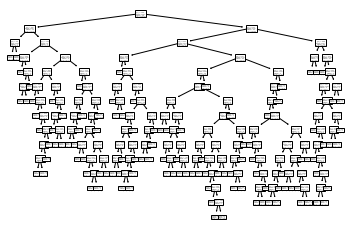

In [43]:
tree.plot_tree(pipe.named_steps['RFC'].estimators_[0])

# Visualization of the created fitted Model:

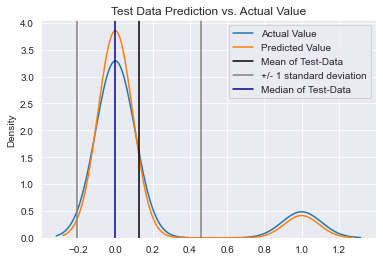

In [44]:
display_model(Y_test, yhat);

# I was able to generate a model, that has an Accuracy_score of 92% with the used Data set.
# Thanks for reviewing :)

# Deep Learning

In [45]:
#!pip install tensorflow

Defaulting to user installation because normal site-packages is not writeable


In [71]:
import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import SGD
from tensorflow.keras import Sequential

In [221]:
tf.version

<module 'tensorflow._api.v2.version' from 'C:\\Users\\Julian\\AppData\\Roaming\\Python\\Python38\\site-packages\\tensorflow\\_api\\v2\\version\\__init__.py'>

In [295]:
scaler_DL = StandardScaler()
X_train_scaled_DL = scaler_DL.fit_transform(X_train)
X_test_scaled_DL = scaler_DL.transform(X_test)

In [296]:

# define the model
model = Sequential()
model.add(Dense(20, input_shape=(X_train_scaled_DL.shape[1],)))
model.add(Dense(30, activation="relu"))
model.add(Dense(20, activation="relu"))
model.add(Dense(10, activation="relu"))
model.add(Dense(5, activation="relu"))
model.add(Dense(1, activation="sigmoid"))#, activation="relu"))

In [292]:
# compile the model
opt = SGD(learning_rate=0.02, momentum=0.9)
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

In [293]:
#verbose = 0 -> show nothing
#verbose = 1 -> show full progress and output
#verbose = 2 -> show output
model.fit(X_train_scaled_DL, Y_train, epochs=10, batch_size=5, verbose=1)

Epoch 1/10


ValueError: in user code:

    C:\Users\Julian\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\training.py:805 train_function  *
        return step_function(self, iterator)
    C:\Users\Julian\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\training.py:795 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    C:\Users\Julian\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\distribute\distribute_lib.py:1259 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    C:\Users\Julian\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\distribute\distribute_lib.py:2730 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    C:\Users\Julian\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\distribute\distribute_lib.py:3417 _call_for_each_replica
        return fn(*args, **kwargs)
    C:\Users\Julian\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\training.py:788 run_step  **
        outputs = model.train_step(data)
    C:\Users\Julian\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\training.py:754 train_step
        y_pred = self(x, training=True)
    C:\Users\Julian\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\base_layer.py:998 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    C:\Users\Julian\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\input_spec.py:255 assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer sequential_51 is incompatible with the layer: expected axis -1 of input shape to have value 8 but received input with shape (None, 7)


In [283]:
loss = model.evaluate(X_test_scaled_DL, Y_test, verbose=1)

10/10 [==============================] - 0s 554us/step - loss: 0.2596 - accuracy: 0.8719


In [284]:
print(loss)
print("binary_crossentropy:", loss[0])
print("accuracy:", loss[1])

[0.2596268653869629, 0.871874988079071]
binary_crossentropy: 0.2596268653869629
accuracy: 0.871874988079071


In [285]:
yhat_DL = model.predict(X_test)

In [286]:
pred = [round(x[0]) for x in yhat_DL]

In [287]:
model_accuracy = metrics.accuracy_score(Y_test, pred)
print(model_accuracy)

0.128125


In [288]:
pred

[1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
